<a href="https://colab.research.google.com/github/ranitha84/gesture_recognition/blob/main/Gesture_Recognition_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. 

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie
 

Each video is a sequence of 30 frames (or images). 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Project_data.zip

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

In [ ]:
!pip install opencv-python


    100% |████████████████████████████████| 88.3MB 487kB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Stored in directory: /root/.cache/pip/wheels/08/40/b7/fb2e8392888c91eb048b26ea0baa9aae808d056e3786204d0b
Successfully built opencv-python


## Importing necessary libraries

In [ ]:
import numpy as np
import os
import datetime
import cv2


In [ ]:
np.random.seed(30)
import random as rn
from keras import backend as K
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D,MaxPooling2D,ZeroPadding3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers


rn.seed(30)
tf.random.set_seed(30)

In [ ]:
drive_path = './Project_data'

train_doc = np.random.permutation(open(drive_path+'/train.csv').readlines())
val_doc = np.random.permutation(open(drive_path+'/val.csv').readlines())

train_path = drive_path+'/train'
val_path = drive_path+'/val'

batch_size = 10

image_width = 100
image_height = 100

# Generator 
- The generator yields the batch data and labels based on the batch size provided.

In [ ]:

class AugmentedDataGenerator:

  def __init__(self, width=image_width, 
               height=image_height, 
               frames=30, 
               channels=3,
               number_samples=20,
               num_classes=5, 
               augment=False, 
               rotate=False):
    self.width= width
    self.height = height
    self.frames = 30
    self.channels = channels
    self.augment = augment
    self.number_samples = number_samples
    self.num_classes = num_classes
    self.rotate= rotate

  def __resize(self, image):
    return cv2.resize(image, (self.height,self.width), interpolation = cv2.INTER_AREA)

  def __normalize(self,image):
    return image/255

  def __augment(self,image):
    # shift image 
    shifted = cv2.warpAffine(image, 
                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                             (image.shape[1], image.shape[0]))
                  
    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

    x0, y0 = np.argwhere(gray > 0).min(axis=0)
    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
    
    # crop image
    cropped=shifted[x0:x1,y0:y1,:]

    image_resized=self.__resize(cropped)
    
    # rotate image
    if self.rotate:
      M = cv2.getRotationMatrix2D((self.width//2,self.height//2),
                                  np.random.randint(-10,10), 1.0)
      image_resized = cv2.warpAffine(image_resized, M, (self.width, self.height))

    return image_resized

  def yield_batches(self,source_path,t,batch,batch_size,img_idx,remaining_seq=0):
      seq_len = remaining_seq if remaining_seq else batch_size
      
      batch_data = np.zeros((seq_len,len(img_idx),self.height,self.width,self.channels)) 
      batch_labels = np.zeros((seq_len,self.num_classes)) 

      if (self.augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.height,self.width,self.channels))

      
      for folder in range(seq_len): 
          imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
          for idx,item in enumerate(img_idx): 
              # read image
              image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_COLOR)
              image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

              # resize image
              image_resized=self.__resize(image)
          
              # normalize image
              batch_data[folder,idx,:,:,0] = self.__normalize(image_resized[:,:,0])
              batch_data[folder,idx,:,:,1] = self.__normalize(image_resized[:,:,1])
              batch_data[folder,idx,:,:,2] = self.__normalize(image_resized[:,:,2])

              # augmented image
              if (self.augment):
                  
                  image_augmented = self.__augment(image) 
                  
                  batch_data_aug[folder,idx,:,:,0] = self.__normalize(image_augmented[:,:,0])
                  batch_data_aug[folder,idx,:,:,1] = self.__normalize(image_augmented[:,:,1])
                  batch_data_aug[folder,idx,:,:,2] = self.__normalize(image_augmented[:,:,2])
              
          
          batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
          

      if (self.augment):
          batch_data=np.concatenate([batch_data,batch_data_aug])
          batch_labels=np.concatenate([batch_labels,batch_labels])

      
      return (batch_data,batch_labels)

  def generator(self, source_path, folder_list, batch_size):
    img_idx = np.round(np.linspace(0,self.frames-1,self.number_samples)).astype(int)
    print( 'Source path = ', source_path, '; batch size =', batch_size,'; Image samples = ',img_idx)
    
    batch_size=batch_size
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
        remaining_seq = len(t)%batch_size

        for batch in range(num_batches): 
            batch_data, batch_labels= self.yield_batches(source_path,t,batch,batch_size,img_idx)
            yield batch_data, batch_labels 

        
        if (len(t)%batch_size):
            batch_data, batch_labels= self.yield_batches(source_path,t,num_batches,batch_size,img_idx,remaining_seq)
            yield batch_data, batch_labels 
    

# Plot

- The method helps to plot the training and validation losses and accuracies respectively.
- A generic method is written to plot the accuracies and losses after each model run

In [ ]:
import matplotlib.pyplot as plt # for plotting


def plot_accuracy(history):
  plt.figure(figsize=(16,6))
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['train', 'validation'])

  plt.subplot(1,2,2)
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['train', 'validation'])

  plt.show() 

# Training model
- Generic method which takes in train and validation generator, batch size and the number of epochs the model should run

- Optimizer used for the entire model run is **Adam**

- **Categorical Cross  entropy and Categorical accuracy** are being used for losses and accuracy respectively

In [ ]:
def train_model( model, batch_size, num_epochs, train_generator, val_generator,learning_rate=0.01, early_stopping=False,_optimizer=None):
    curr_dt_time = datetime.datetime.now()
    num_train_sequences = len(train_doc)
    print('# training sequences =', num_train_sequences)
    num_val_sequences = len(val_doc)
    print('# validation sequences =', num_val_sequences)
    print ('# epochs =', num_epochs)
    print ('learning_rate =', learning_rate)


    print('Number of epochs {}'.format(num_epochs))
    print('Batch Size {}'.format(batch_size))
    print('Current Date time {}'.format(curr_dt_time))

    # Defining call back lists

    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}--{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 save_weights_only=False, 
                                 mode='auto')

    LR = ReduceLROnPlateau(monitor='val_loss',factor=0.2, patience=2, verbose=1,mode='auto')

    callbacks_list = [checkpoint, LR]

    if early_stopping:
      ER = EarlyStopping(monitor='val_categorical_accuracy', patience=10, verbose=1)
      callbacks_list.append(ER)
    
    if _optimizer == None:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif _optimizer =='sgd':
        print('Optimizer {}',_optimizer)
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,momentum=0.9)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
   
    if (num_train_sequences%batch_size) == 0:
      steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    
    history = model.fit(train_generator, 
              steps_per_epoch=steps_per_epoch, 
              epochs=num_epochs, 
              verbose=1, 
              callbacks=callbacks_list, 
              validation_data=val_generator, 
              validation_steps=validation_steps, 
              class_weight=None, 
              initial_epoch=0,
              workers=1)
    plot_accuracy(history)
    K.clear_session()

# Model Generator
- This can takes in the input shape as parameter
- Differnt models to be built are part of this class and used for generating models and training them respectively

In [ ]:

from keras.applications import ResNet50V2, VGG16, mobilenet
from keras.layers.pooling import GlobalAveragePooling2D
class ModelGenerator():

  def __init__(self,input_shape=(30, image_height,image_width,3), num_classes=5):
    self.input_shape= input_shape
    self.num_classes = num_classes

  
  def model_cv3D(self,dropout=0.25):

      model = Sequential()
      model.add(Conv3D(16, (2,2,2), padding='same',
                input_shape=self.input_shape))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(32, (2, 2, 2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(64, (2, 2, 2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(128, (2, 2, 2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Flatten())
      model.add(Dense(128,activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(dropout))

      model.add(Dense(64,activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(dropout))


      model.add(Dense(self.num_classes,activation='softmax'))

      return model
  
  def model_cv3D2(self,dropout=0.25):
      '''
        Additional layers have been added to the the Conv3D with 2*2*2 filter
      '''
      model = Sequential()
      model.add(Conv3D(16, (2,2,2), padding='same',
                input_shape=self.input_shape))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(Conv3D(16, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(32, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(Conv3D(32, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(64, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(Conv3D(64, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(128, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(Conv3D(128, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))
      

      model.add(Flatten())
      model.add(Dense(64,activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(dropout))

      model.add(Dense(64,activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(dropout))


      model.add(Dense(self.num_classes,activation='softmax'))

      return model

  
  def model_cv3D3(self,dropout=0.25):
      '''
      Additional layers have been added and dropouts added to the the Conv3D with 2*2*2 filter
      '''
      model = Sequential()
      model.add(Conv3D(16, (2,2,2), padding='same',
                input_shape=self.input_shape))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(Conv3D(16, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))
      model.add(Dropout(dropout))

      model.add(Conv3D(32, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(Conv3D(32, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))
      model.add(Dropout(dropout))

      model.add(Conv3D(64, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(Conv3D(64, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))
      model.add(Dropout(dropout))

      model.add(Conv3D(128, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(Conv3D(128, (2,2,2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))
      model.add(Dropout(dropout))
      

      model.add(Flatten())
      model.add(Dense(64,activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(dropout))

      model.add(Dense(64,activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(dropout))


      model.add(Dense(self.num_classes,activation='softmax'))

      return model

  
  def model_cv3D4(self,dropout=0.25):
      '''
        Reduced number of parameters
      '''
      model = Sequential()
      model.add(Conv3D(8, (3, 3, 3), padding='same',
                input_shape=self.input_shape))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(16, (3, 3, 3), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(32, (2, 2, 2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(64, (2, 2, 2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))
      
      model.add(Flatten())
      model.add(Dense(64,activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(dropout))

      model.add(Dense(64,activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(dropout))

      model.add(Dense(self.num_classes,activation='softmax'))

      return model

  def model_cv3D5(self,dropout=0.25):
      '''
        Reduced number of parameters
      '''
      model = Sequential()
      model.add(Conv3D(8, (3, 3, 3), padding='same',
                input_shape=self.input_shape))
      model.add(Activation('relu'))
      model.add(BatchNormalization(momentum=0.9))
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(16, (3, 3, 3), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization(momentum=0.9))
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(32, (2, 2, 2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization(momentum=0.9))
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(64, (2, 2, 2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization(momentum=0.9))
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))
      
      model.add(Flatten())
      model.add(Dense(64,activation='relu'))
      model.add(BatchNormalization(momentum=0.9))
      model.add(Dropout(dropout))

      model.add(Dense(64,activation='relu'))
      model.add(BatchNormalization(momentum=0.9))
      model.add(Dropout(dropout))

      model.add(Dense(self.num_classes,activation='softmax'))

      return model

  
  def model_lstm(self, dropout=0.25):
      '''
        LSTM model
      '''
      model = Sequential()

      model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                input_shape=self.input_shape))
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2, 2))))
      
      model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2, 2))))
      
      model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2, 2))))
      
      model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2, 2))))
      
      model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2, 2))))
      

      model.add(TimeDistributed(Flatten()))


      model.add(LSTM(128))
      model.add(Dropout(dropout))
      
      model.add(Dense(128,activation='relu'))
      model.add(Dropout(dropout))
      
      model.add(Dense(self.num_classes, activation='softmax'))

      return model

  
  def model_gru(self, dropout=0.25):
    '''
      GRU Model
    '''
    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                              input_shape=self.input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    

    model.add(TimeDistributed(Flatten()))


    model.add(GRU(128))
    model.add(Dropout(dropout))
    
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(dropout))
    
    model.add(Dense(self.num_classes, activation='softmax'))

    return model

  def model_vgg16_gru(self,dropout=0.25):
      '''
        Transfer learning with VGG16 
      '''
      vgg16 = VGG16(weights='imagenet', include_top=False)

      model = Sequential()
      model.add(TimeDistributed(vgg16,input_shape=self.input_shape))
      
      
      for layer in model.layers:
          layer.trainable = False
      
      
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2, 2))))
      model.add(TimeDistributed(Flatten()))

      model.add(GRU(128))
      model.add(Dropout(dropout))
      
      model.add(Dense(128,activation='relu'))
      model.add(Dropout(dropout))
      
      model.add(Dense(self.num_classes, activation='softmax'))

      return model

  def model_mobilenet_gru(self,dropout=0.25, dense_layer=256):
      '''
        Transfer learning with Mobilenet 
      '''
      mobile = mobilenet.MobileNet(weights='imagenet', include_top=False)

      model = Sequential()
      model.add(TimeDistributed(mobile,input_shape=self.input_shape))


      trainable = 9
      for layer in model.layers[:-trainable]:
          layer.trainable = False
      for layer in model.layers[-trainable:]:
          layer.trainable = True
          

      model.add(TimeDistributed(BatchNormalization(momentum=0.9)))
      model.add(TimeDistributed(GlobalAveragePooling2D()))


      model.add(TimeDistributed(Flatten()))
      model.add(GRU(dense_layer))
      model.add(Dropout(0.25))

      model.add(Dense(dense_layer,activation='relu'))
      model.add(Dropout(0.5))

      model.add(Dense(self.num_classes, activation='softmax'))

      return model

## Testing with differnt hyper parameters before proceeding with actual model building

#### Sampling with 20 frames from each video and batch size as 20 and number of epochs run is 3 

# training sequences = 663
# validation sequences = 100
# epochs = 3
learning_rate = 0.01
Number of epochs 3
Batch Size 20
Current Date time 2021-03-05 14:21:32.877182
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 100, 100, 16)  400       
_________________________________________________________________
activation (Activation)      (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 50, 50, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 50, 50, 32)    4128      
_________________________________________________________________
activation_1 (Activa

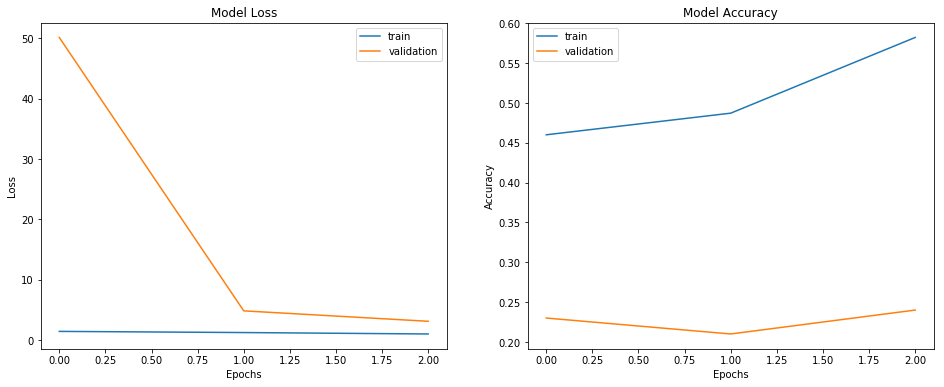

In [ ]:
train_gen = AugmentedDataGenerator()
val_gen = AugmentedDataGenerator()

batch_size = 20
num_epochs =3

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(20,image_height,image_width,3))

model = model_generator.model_cv3D()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

#### Sampling with 16 frames, batch size as 30 and number of epoch is 3

# training sequences = 663
# validation sequences = 100
# epochs = 3
Number of epochs 3
Batch Size 30
Current Date time 2021-03-01 01:41:35.638534
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_1 (Activation)    (None, 8, 50

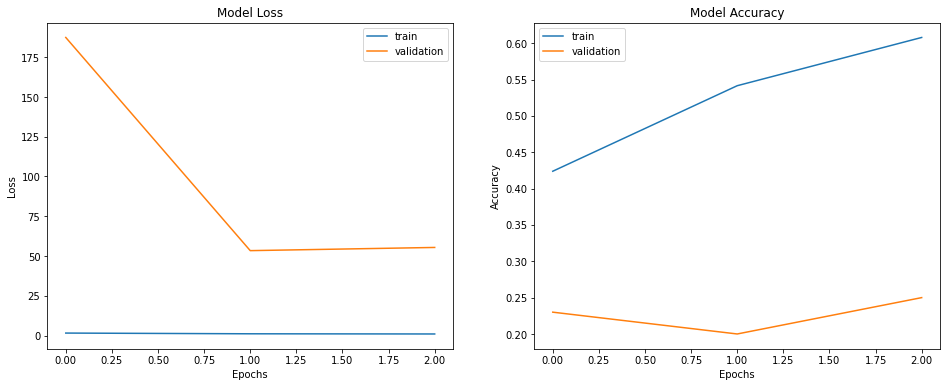

In [ ]:
batch_size = 30
num_epochs =3
frames_sample=16

train_gen = AugmentedDataGenerator(number_samples=frames_sample)
val_gen = AugmentedDataGenerator(number_samples=frames_sample)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,image_height,image_width,3))

model = model_generator.model_cv3D()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

# Hyperparameters considered for training the models

We see a considerable increase on speed of the training the model with increase in batch. But with reduction in  number of frames, we see a slight drop in the valdiation accuracy. 
The following hyper parameters are considered to train the rest of the model
- Frame sample - 20
- Batch Size - 40
- Number of epochs - 25


# Model # 1 Conv3D without augmentation


# training sequences = 663
# validation sequences = 100
# epochs = 25
learning_rate = 0.01
Number of epochs 25
Batch Size 40
Current Date time 2021-03-05 14:25:46.451177
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 100, 100, 16)  400       
_________________________________________________________________
activation (Activation)      (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 50, 50, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 50, 50, 32)    4128      
_________________________________________________________________
activation_1 (Acti

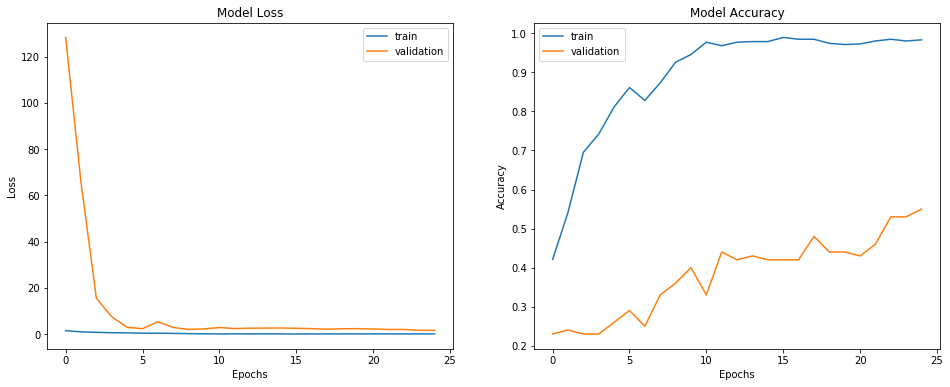

In [ ]:
frames_sample=20
batch_size=40
num_epochs=25

train_gen = AugmentedDataGenerator(number_samples=frames_sample)
val_gen = AugmentedDataGenerator(number_samples=frames_sample)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,image_height,image_width,3))

model = model_generator.model_cv3D()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

<mark>**Results**</mark> We see the model over fits in our case. Lets try to augment the dataset and see whether there is any improvement in the overall validation accuracy

# Model 2 - Using the same architecture as above With augmentation 

# training sequences = 663
# validation sequences = 100
# epochs = 25
learning_rate = 0.01
Number of epochs 25
Batch Size 40
Current Date time 2021-03-05 14:43:24.898867
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 100, 100, 16)  400       
_________________________________________________________________
activation (Activation)      (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 50, 50, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 50, 50, 32)    4128      
_________________________________________________________________
activation_1 (Acti

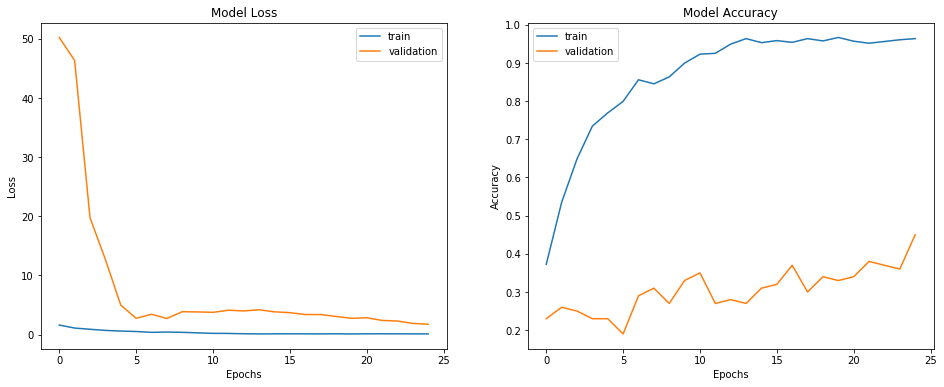

In [ ]:
train_gen = AugmentedDataGenerator(width=image_width, height=image_height,number_samples=frames_sample,augment=True)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=image_width, height=image_height)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,image_height,image_width,3))

model = model_generator.model_cv3D()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

<mark>**Results**:</mark> Still the model is overfitting. Lets try to add additional conv3d layers and see whether we see improvement in the validation accuracy

## Model 3 - Added Additional Layers and without augmentation


# training sequences = 663
# validation sequences = 100
# epochs = 25
learning_rate = 0.01
Number of epochs 25
Batch Size 40
Current Date time 2021-03-05 15:16:19.398803
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 100, 100, 16)  400       
_________________________________________________________________
activation (Activation)      (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 100, 100, 16)  64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 20, 100, 100, 16)  2064      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalizatio

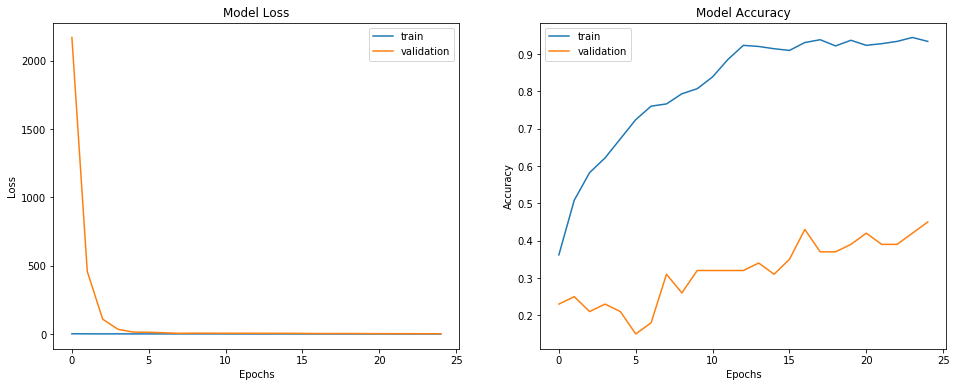

In [ ]:
train_gen = AugmentedDataGenerator(width=image_width, height=image_height,number_samples=frames_sample)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=image_width, height=image_height)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,image_height,image_width,3))

model = model_generator.model_cv3D2()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

<mark>**Results**:</mark> Still the model is overfitting. Lets try augment training data set and whether the model performs better or not

## Model 4 - Additional Layers and with augmentation




# training sequences = 663
# validation sequences = 100
# epochs = 25
learning_rate = 0.01
Number of epochs 25
Batch Size 40
Current Date time 2021-03-05 15:34:43.731773
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 100, 100, 16)  400       
_________________________________________________________________
activation (Activation)      (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 100, 100, 16)  64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 20, 100, 100, 16)  2064      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalizatio

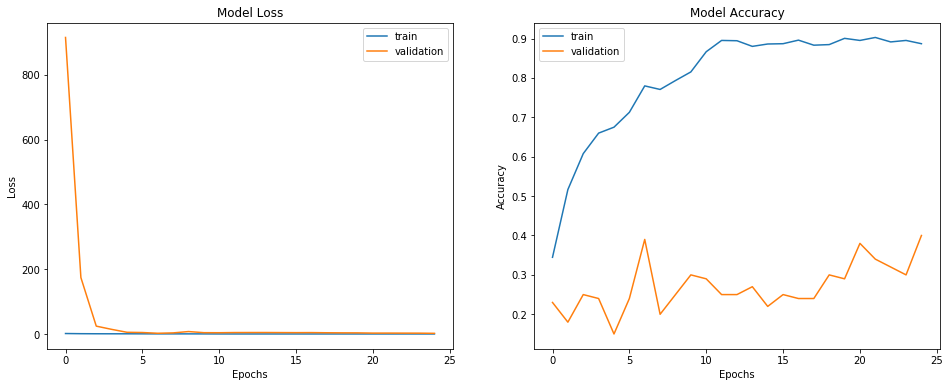

In [ ]:
train_gen = AugmentedDataGenerator(width=image_width, height=image_height,number_samples=frames_sample, augment=True)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=image_width, height=image_height)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,image_height,image_width,3))

model = model_generator.model_cv3D2()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

<mark>**Results**:</mark> Still the model is overfitting. Lets try to add additional dropout to conv3d layers and see whether we see improvement in the validation accuracy

## Model 5 - Additional Layers and added Dropout to CNN layer and without augmentation

# training sequences = 663
# validation sequences = 100
# epochs = 25
learning_rate = 0.01
Number of epochs 25
Batch Size 40
Current Date time 2021-03-05 16:08:43.233555
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 100, 100, 16)  400       
_________________________________________________________________
activation (Activation)      (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 100, 100, 16)  64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 20, 100, 100, 16)  2064      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalizatio

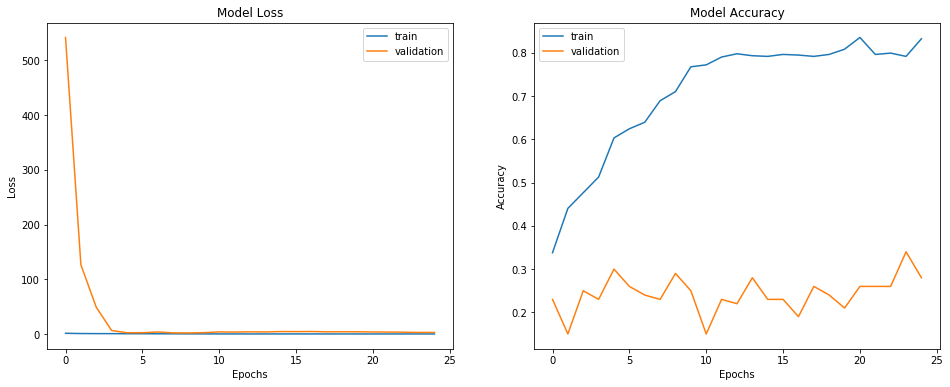

In [ ]:
train_gen = AugmentedDataGenerator(width=image_width, height=image_height,number_samples=frames_sample)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=image_width, height=image_height)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,image_height,image_width,3))

model = model_generator.model_cv3D3()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

<mark>**Results**:</mark> We see a drop in both training and validation accuracy and the model continues to over fit 

---



## Model 6 with Augmentation and Early Stopping
- We are trying to run more number of epochs to see whether there is any  improvement in model validation accuracy. In order to save computational resources, we have enabled Early stopping with patience as 10



# training sequences = 663
# validation sequences = 100
# epochs = 100
learning_rate = 0.01
Number of epochs 100
Batch Size 40
Current Date time 2021-03-05 16:27:14.832084
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 100, 100, 16)  400       
_________________________________________________________________
activation (Activation)      (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 100, 100, 16)  64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 20, 100, 100, 16)  2064      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalizat

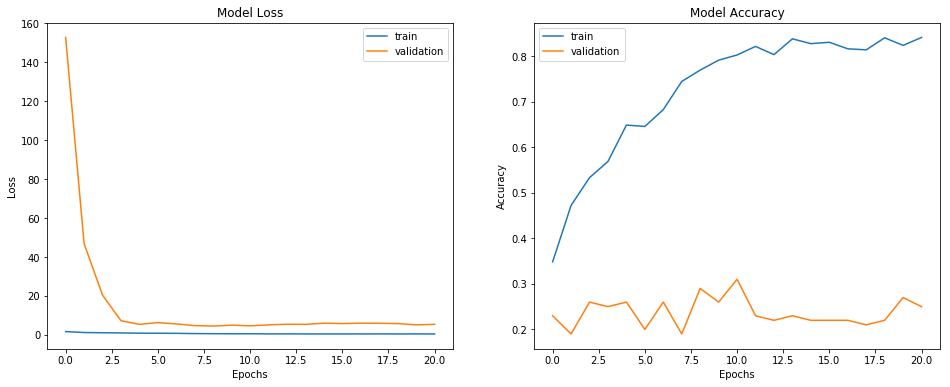

In [ ]:
train_gen = AugmentedDataGenerator(width=image_width, height=image_height,number_samples=frames_sample,augment=True)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=image_width, height=image_height)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,image_height,image_width,3))

model = model_generator.model_cv3D3()

train_model(model=model,batch_size=batch_size,num_epochs=100,train_generator=train_generator,val_generator=val_generator,early_stopping=True)

<mark>**Results**:</mark> No Significant improvement in the model. Hence lets try to reduce the parameters and change the initial few layers filter size to see whether it improves the model performance

## Model 7 with image width and height as 120 and reduced parameters

### <mark>Augmenting the data</mark>

#### Running 50 Epochs with a batch size of 30 and sample size of 20


# training sequences = 663
# validation sequences = 100
# epochs = 50
learning_rate = 0.01
Number of epochs 50
Batch Size 30
Current Date time 2021-03-05 16:56:33.361025
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 120, 120, 8)   656       
_________________________________________________________________
activation (Activation)      (None, 20, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 60, 60, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 60, 60, 16)    3472      
_________________________________________________________________
activation_1 (Acti

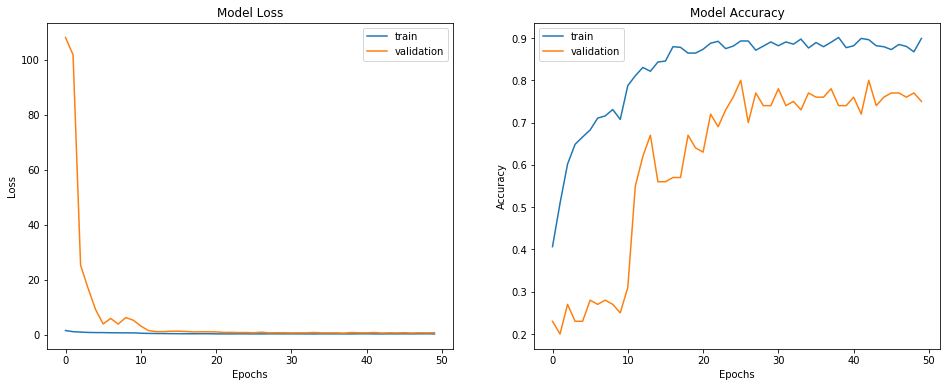

In [ ]:
batch_size = 30
num_epochs = 50
frames_sample = 20
train_gen = AugmentedDataGenerator(width=120, height=120,number_samples=frames_sample,augment=True)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=120, height=120)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,120,120,3))

model = model_generator.model_cv3D4()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

<mark>**Result**</mark> With this architecture we see a considerable improvement in both the categorical and validation accuracy. However there is still scope to improve the validation and training accuracy and reduce the overfitting problem. Hence we tried to fine tune this architecture to achieve our goal

## Model 8 with image width and height as 120 and reduced parameters

#### Running 30 Epochs with a batch size of 30 and sample size of 20

#### Augmenting the images with additional rotation

# training sequences = 663
# validation sequences = 100
# epochs = 30
learning_rate = 0.01
Number of epochs 30
Batch Size 30
Current Date time 2021-03-05 18:08:19.801153
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 120, 120, 8)   656       
_________________________________________________________________
activation (Activation)      (None, 20, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 60, 60, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 60, 60, 16)    3472      
_________________________________________________________________
activation_1 (Acti

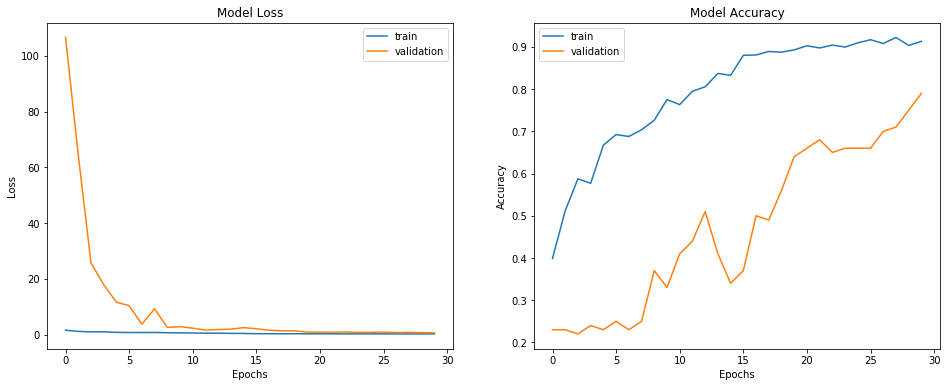

In [ ]:
batch_size = 30
num_epochs = 30
frames_sample = 20
train_gen = AugmentedDataGenerator(width=120, height=120,number_samples=frames_sample,augment=True,rotate=True)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=120, height=120)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,120,120,3))

model = model_generator.model_cv3D4()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

<mark>**Result**</mark> After we incorporated image rotation to the data augmentation techniques, we had been following so far, we see increase in both training and validation accuracy. However, there is still overfitting problem is what we observed

## Model 9 with image width and height as 120 and optimizer as sgd

# training sequences = 663
# validation sequences = 100
# epochs = 30
learning_rate = 0.01
Number of epochs 30
Batch Size 30
Current Date time 2021-03-06 04:31:37.792376
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 120, 120, 8)   656       
_________________________________________________________________
activation (Activation)      (None, 20, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 60, 60, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 60, 60, 16)    3472      
_________________________________________________________________
activation_1 (Acti

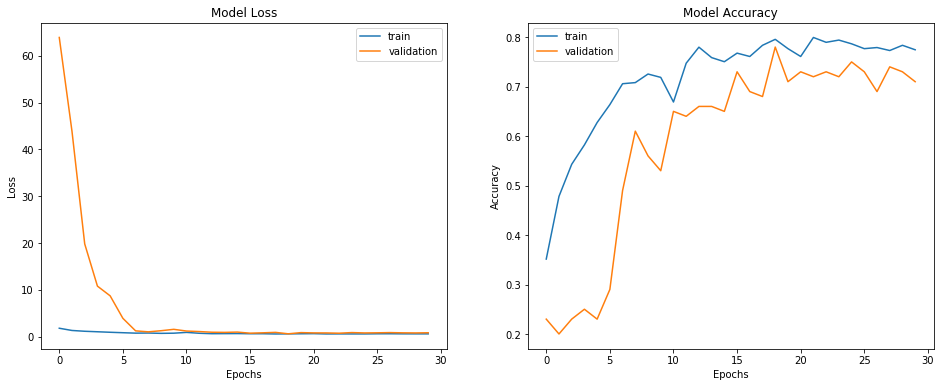

In [ ]:
batch_size = 30
num_epochs = 30
frames_sample = 20
train_gen = AugmentedDataGenerator(width=120, height=120,number_samples=frames_sample,augment=True,rotate=True)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=120, height=120)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,120,120,3))

model = model_generator.model_cv3D4()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator,_optimizer='sgd')

<mark>**Result**</mark>  We no longer see overfitting problem. However we felt there is still scope for improving model accuracy. 

## Model 10 with image width and height as 120 and adding momentum to Batch Normalization

# training sequences = 663
# validation sequences = 100
# epochs = 30
learning_rate = 0.01
Number of epochs 30
Batch Size 30
Current Date time 2021-03-06 03:47:39.562757
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 120, 120, 8)   656       
_________________________________________________________________
activation (Activation)      (None, 20, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 60, 60, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 60, 60, 16)    3472      
_________________________________________________________________
activation_1 (Acti

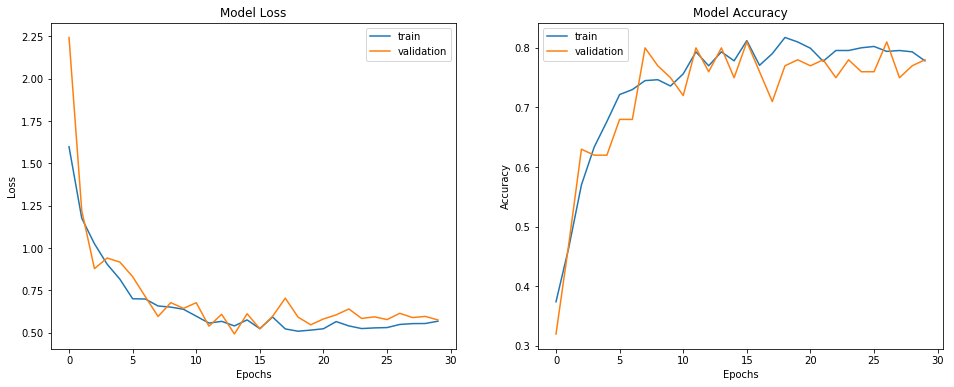

In [ ]:
batch_size = 30
num_epochs = 30
frames_sample = 20
train_gen = AugmentedDataGenerator(width=120, height=120,number_samples=frames_sample,augment=True,rotate=True)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=120, height=120)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,120,120,3))

model = model_generator.model_cv3D5()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

<mark>**Result**</mark> We see almost training and validation accuracy are same and this seems to be a great model with Conv3D and its performance seems to be great compared to other variants we tried. 

With more number of epochs run, we should definitely get a better performing model. However, we wanted to try other options before training this model for more number of epochs

## Model 11 LSTM model with image size as 120 
#### Training has been augmented and rotated
- No.of Samples -20
- Batch Size - 30
- No.of Epochs - 25

# training sequences = 663
# validation sequences = 100
# epochs = 25
learning_rate = 0.01
Number of epochs 25
Batch Size 30
Current Date time 2021-03-05 19:05:10.660080
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5

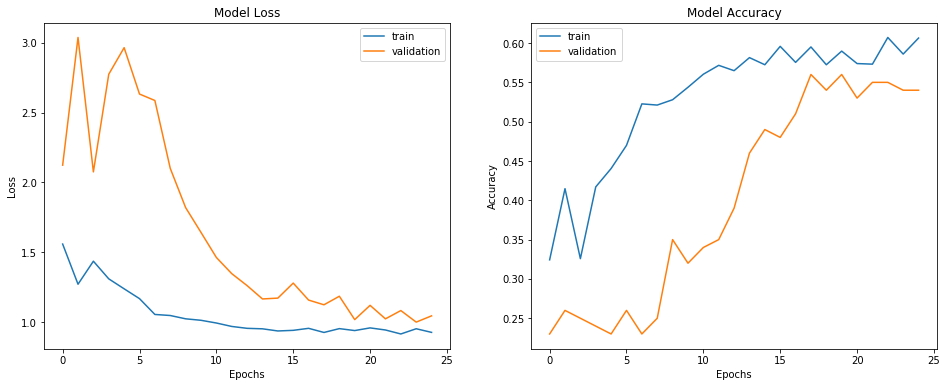

In [ ]:
batch_size = 30
num_epochs = 25
frames_sample = 20
train_gen = AugmentedDataGenerator(width=120, height=120,number_samples=frames_sample,augment=True,rotate=True)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=120, height=120)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,120,120,3))

model = model_generator.model_lstm()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

<mark>**Result**</mark> The model seems to be underperforming. Both the training and validation accuracy were low even after 25 epochs run. However, we don’t see too overfitting problem here. We wanted to try GRU to see how it performs on the same model architecture

## Model 12 GRU model with image size as 120 
#### Training has been augmented and rotated
- No.of Samples -20
- Batch Size - 30
- No.of Epochs - 60
- Early stopping enabled on validation accuracy

# training sequences = 663
# validation sequences = 100
# epochs = 60
learning_rate = 0.01
Number of epochs 60
Batch Size 30
Current Date time 2021-03-06 05:13:11.241089
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5

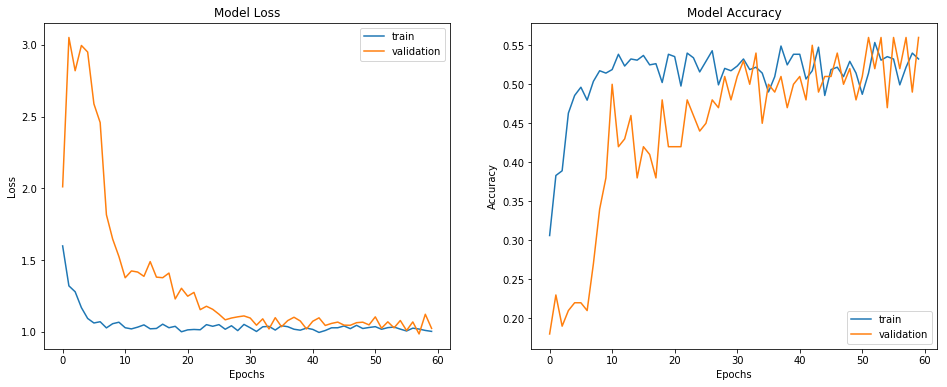

In [ ]:
batch_size = 30
num_epochs = 60
frames_sample = 20
train_gen = AugmentedDataGenerator(width=120, height=120,number_samples=frames_sample)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=120, height=120)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,120,120,3))

model = model_generator.model_gru()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

<mark>**Result**</mark> Even after 60 epochs run, we don’t see appreciable increase in model performance with GRU architecture. 

We wanted to try using transfer learning along with GRU to see how the model performs

# Transfer Learning

## Model 13 with VGG 16 and GRU

58892288/58889256 [==============================] - 2s 0us/step
# training sequences = 663
# validation sequences = 100
# epochs = 30
learning_rate = 0.01
Number of epochs 30
Batch Size 30
Current Date time 2021-03-06 05:54:21.947325
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 16, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 3, 3, 512)     2048      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 1, 1, 512)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 512)           0         
_________________________________________________________________
gru (GRU)                    (None, 128)               246528    
___________________

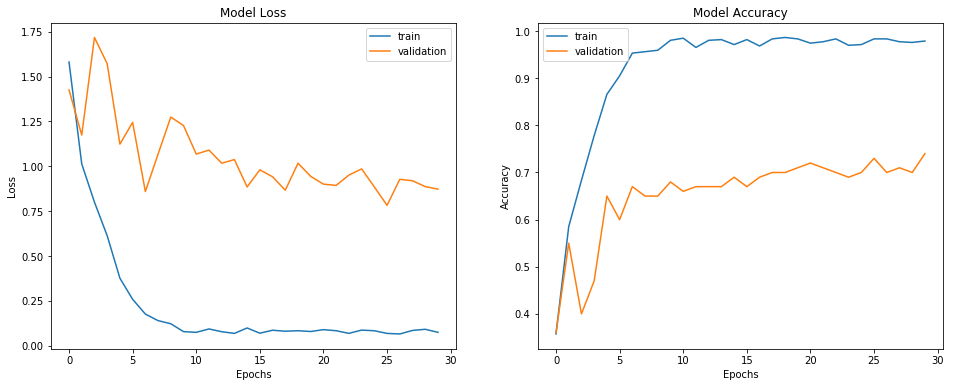

In [ ]:
batch_size = 30
num_epochs = 30
frames_sample = 16
train_gen = AugmentedDataGenerator(width=120, height=120,number_samples=frames_sample)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=120, height=120)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,120,120,3))

model = model_generator.model_vgg16_gru()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

<mark>**Result**</mark> Since we froze the initial layers of vgg16 , the number of trainable parameters were considerable. We see that the model is performing extremely well on the training data while the validation accuracy is comparable but overfitting problem still exists. 

We wanted to try the transfer learning with light weight model, since we wanted to use the same on the webcam which would be fit to the TV. So we choose mobilenet to see whether we can fine tune its parameters and get good accuracy


## Model 14 with Mobile Net and GRU

W0306 06:26:42.634058 140374563067712 mobilenet.py:216] `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


# training sequences = 663
# validation sequences = 100
# epochs = 30
learning_rate = 0.01
Number of epochs 30
Batch Size 20
Current Date time 2021-03-06 06:26:46.098885
Optimizer {} sgd
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 1024)          0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 1024)          0         
_________________________________________________________________
gru (GRU)                    (None, 256)               984576    
_________________________________________________________________
d

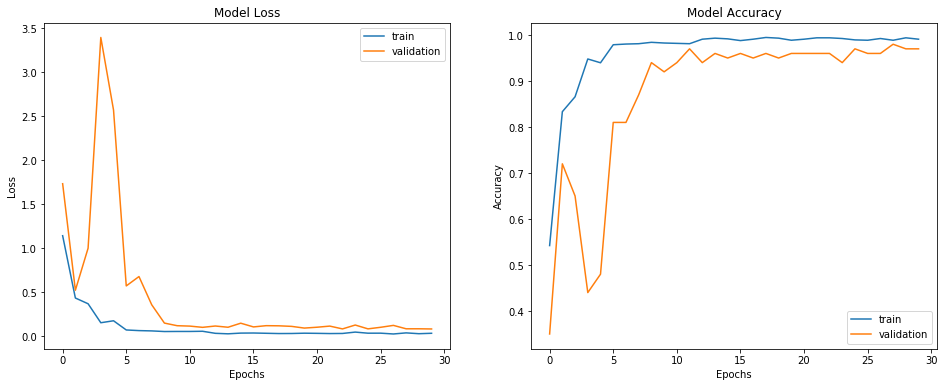

In [ ]:
batch_size = 20
num_epochs = 30
frames_sample = 20
train_gen = AugmentedDataGenerator(width=120, height=120,number_samples=frames_sample,augment=True,rotate=True)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=120, height=120)

model_generator = ModelGenerator(input_shape=(frames_sample,120,120,3))

model = model_generator.model_mobilenet_gru()
train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)


train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator,_optimizer='sgd')


<mark>**Result**</mark> We see both the validation and training accuracy has improved very layers. In this model, we tried to make the last 9 layers weights as trainable and after much fine tuning, we got a very good validation and training accuracy. 

However, we were not very happy with the number of trainable parameters. Since our model should fit into webcam we wanted to try and reduce the number of trainable parameters

## Final Best Model 

##  Model 15 Mobile net+ GRU  with reduced layers

W0306 07:21:24.383388 140374563067712 mobilenet.py:216] `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


# training sequences = 663
# validation sequences = 100
# epochs = 15
learning_rate = 0.01
Number of epochs 15
Batch Size 20
Current Date time 2021-03-06 07:21:28.008930
Optimizer {} sgd
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 1024)          0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 1024)          0         
_________________________________________________________________
gru (GRU)                    (None, 64)                209280    
_________________________________________________________________
d

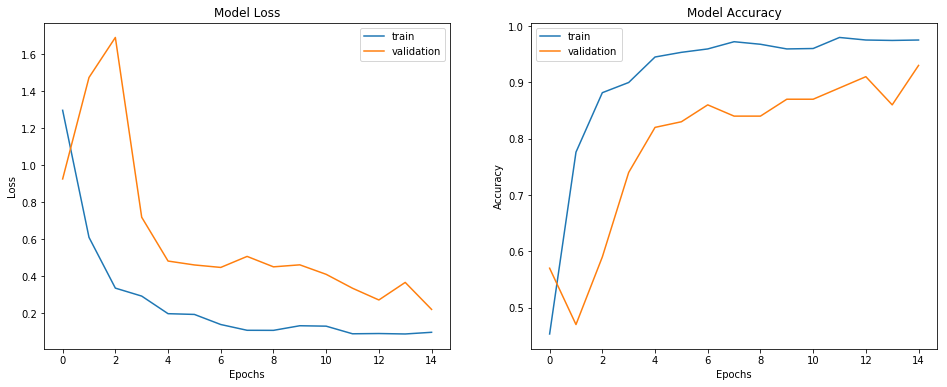

In [ ]:
batch_size = 20
num_epochs = 15
frames_sample = 20
train_gen = AugmentedDataGenerator(width=100, height=100,number_samples=frames_sample,augment=True,rotate=True)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=100, height=100)

model_generator = ModelGenerator(input_shape=(frames_sample,100,100,3))

model = model_generator.model_mobilenet_gru(dense_layer=64)
train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)


train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator,_optimizer='sgd')



#### Results

- Overall after trying 15 different models, we observed that Mobile net with last 9 layers trained is giving us a good training and validation accuracy

- Overall we obtained accuracy of 97% and valdiation accuracy of 93%

- Number of trainable parameters was 3,422,789

- Total number of epochs used for achieving the above accuracy - 15

- Batch size used - 20
